# Computer Assignment #3
## Ali Hamzehpour 810100129
## Naive Bayes
### Problem Description
We are given a [dataset of handwritten persian digits](http://farsiocr.ir/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%AF%D8%A7%D8%AF%D9%87/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%A7%D8%B1%D9%82%D8%A7%D9%85-%D8%AF%D8%B3%D8%AA%D9%86%D9%88%DB%8C%D8%B3-%D9%87%D8%AF%DB%8C/)  and we have to implement a Naive Bayes model for this dataset to classify handwritten persian digits. After preprocessing the data, two different naive bayes model should be implemented: Gaussian Naive Bayes and Bernoulli Naive Bayes. Then we are asked to evaluate our models with different approaches.

### Preprocessing
First we load our dataset. We have two files:
* ```data.pkl``` contains the images of digits.
* ```labels.pkl``` contains the labels(what digit it is) of each images in the first file.

In [2]:
import pickle 
import numpy as np

data_file = open(f"dataset/data.pkl", "rb")
label_file = open(f"dataset/label.pkl", "rb")
raw_data = pickle.load(data_file)
labels = np.array(pickle.load(label_file))

To get a better understanding of dataset I plotted some random images. As you can see, The images are in different size and are gray-scaled.

In [3]:
import matplotlib.pyplot as plt

def show_random_img(data, labels):
    data_size = len(data)
    random_index = np.random.randint(0, data_size - 1)
    print(f"label is {labels[random_index]}")
    random_img = data[random_index]
    plt.imshow(random_img, cmap='gray_r')

label is 6


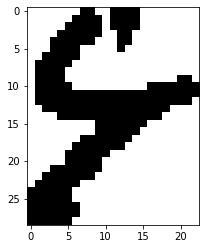

In [4]:
show_random_img(raw_data, labels)

label is 9


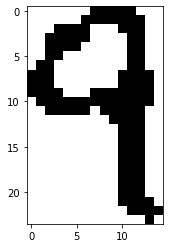

In [5]:
show_random_img(raw_data, labels)

label is 8


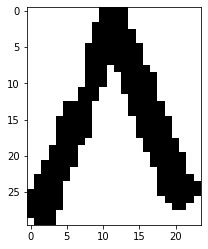

In [6]:
show_random_img(raw_data, labels)

As shown above, the images have different scales and that will be problematic in Naive Bayes because we should have equal number of features for each data in Naive Bayes so I resized all of them to 20*20 images using opencv library.

label is 6


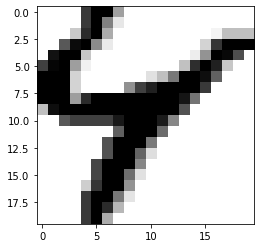

In [7]:
from cv2 import resize #, INTER_LINEAR, INTER_NEAREST, INTER_NEAREST_EXACT

RESIZE_WIDTH = 20
RESIZE_HEIGHT = 20

resized_data = np.array(list((map(lambda x: resize(x, (RESIZE_WIDTH, RESIZE_HEIGHT)), raw_data))))
show_random_img(resized_data, labels)

Then I scaled the data so each pixel value ranges from 0 to 1. The reason is in Bernoulli Naive Bayes our data should be 0 or 1.(if we didn't scale data it would be 255 or 0 and Naive Bayes formula wouldn't work properly.) and also in this case we can classify pale images better since these images will be scaled from 0 to 1 too.

label is 7


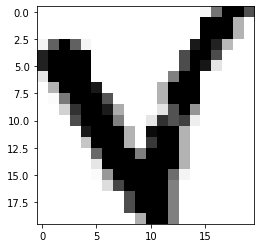

In [8]:
scaled_data = np.apply_along_axis(lambda x: x / 255, axis = 1, arr = resized_data)
show_random_img(scaled_data, labels)

We have to split our data into two parts: train and test. We build our model with train data and then evaluate it with test data. I chose 80% of the data for training and the other 20% for testing. The reason is the train data should be larger so our model sees more data in the training process and become better. For testing we take a small portion of the whole data but it also shouldn't be too small because we need enough data to check the model's accuracy with it.

In [9]:
SPLIT_PERCENTAGE = 0.8

split_index = int(len(scaled_data) * SPLIT_PERCENTAGE)
train_data, test_data = np.split(scaled_data, [split_index])
train_labels, test_labels = np.split(labels, [split_index])

In [10]:
train_data.shape

(4800, 20, 20)

I plotted a bar plot for each digit to compare the number of images in train and test data for each digit. As you can see, the plots are similar. 

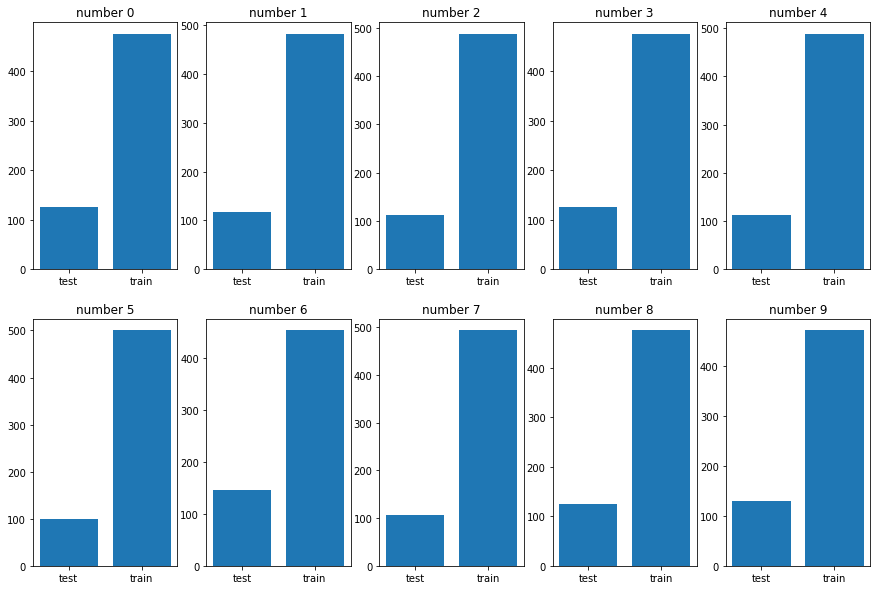

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(15, 10))
axs = axs.flatten()

for i in range(10):
    train_samples = len(train_data[train_labels == i])
    test_samples = len(test_data[test_labels == i])
    axs[i].bar(["test", "train"], (test_samples, train_samples))
    axs[i].set_title(f"number {i}")
    
plt.show()

I plotted one image from each digit from the train data:

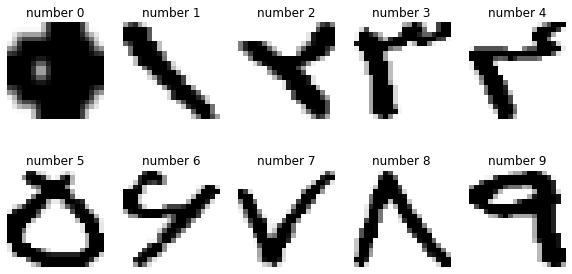

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()
for i in range(10):
    img = train_data[train_labels == i][np.random.randint(1,100)]
    axs[i].imshow(img, cmap='gray_r')
    axs[i].axis('off')
    axs[i].set_title(f"number {i}")
plt.show()

### Naive Bayes Classification

We use Bayes' Theorem in Naive Bayes Classification:
        $$ P(c|x) = \frac{P(x|c)P(c)}{P(x)} $$

In this formula $c$ is the label of an image and $x$ is the value of a pixel in the image.

* $P(c|x)$ Posterior Priority:<br>
        Is the probability of $c$ after observing $x$. In our problem, it means probabilty of the image labeled as $c$ after checking the value of a pixel.

* $P(x|c)$ Likelihood:<br>
        Is the probability of $x$ after observing $c$. In our problem, it means probabilty of a pixel's value = $x$ after observing the image's label.

* $P(c)$ Class Prior Probability:<br>
        Is the probability of $c$ with no conditions. In our problem, it means the probability of the image's label = $c$ with no conditions.

* $P(x)$ Evidence(Predictor Prior Probability):<br>
        Is the probability of $x$ with no conditions. In our problem, it means the probability of a pixel's value = $x$ with no conditions.

The term ```prior``` means that we have no conditions and the term ```posterior``` means we've had some observations.
So we can calculate $P(c|x)$ for each pixel and for the whole image we assume that the pixels are independent and use this formula:

$$ P(c|X) = P(x_1|c) \times P(x_2|c) \times \ldots \times P(x_n|c) \times P(c) \times \frac{1}{Z} $$

where $X$ is the vector of all pixel values in that image and and $x_i$ is the value of a pixel in the image. $Z$ is a constant to normalize the probabilities and since it's constant we ignore it in calculations.


### Gaussian Naive Bayes

In Gaussian Naive Bayes we suppose that the pixel values have normal distribution so for each pixel and class:

$$ P(X|Y = c) = \frac{1}{\sqrt{2\pi\sigma_c^2}}e^{\frac{-(x-\mu_c)^2}{2\sigma_c^2}} $$

$\mu_c$ is the mean of a pixel value when the label is $c$ <br>
$\sigma_c^2$ is the variance of a pixel value when the label is $c$

I wrote a `GaussianNaiveBayes` class that in its constructor calls `train` function to calculate $\mu_c$ and $\sigma_c^2$ using train data and it also has a `predict` function which gets a new image and classifies its label with gaussian naive bayes approach.

#### Gaussian Naive Bayes Smoothing

We may face a problem in this approach. $\sigma_c$ may become 0 then in the Gaussian Distribution formula we will have division by 0.(For example when our label is 1, a pixel might be always black so its variance is 0.) To solve this problem I added a small value to all the variances.

In [31]:
NUM_OF_CLASSES = 10
NUM_OF_FEATURES = 400
GAUSSIAN_SMOOTHING_VALUE = 0.01

class GaussianNaiveBayes:
    def __init__(self, train_data, train_labels, smoothing = True):
        self.train(train_data, train_labels, smoothing)
            
    def train(self, train_data, train_labels, smoothing):
        train_size = len(train_data)
        self.class_mean = np.zeros((NUM_OF_CLASSES, NUM_OF_FEATURES))
        self.class_var = np.zeros((NUM_OF_CLASSES, NUM_OF_FEATURES))
        self.class_prob = [0] * NUM_OF_CLASSES
        for i in range(NUM_OF_CLASSES):
            train_class = train_data[train_labels == i]
            self.class_prob[i] = len(train_class) / train_size
            self.class_mean[i, :] = train_class.mean(axis = 0).flatten()
            self.class_var[i, :] = train_class.var(axis = 0).flatten()
        if smoothing:
            self.class_var += GAUSSIAN_SMOOTHING_VALUE

    def predict(self, test_sample):
        test_sample = test_sample.flatten()
        posterior_prob = []
        for i in range(NUM_OF_CLASSES):
            numerator = np.exp(-((test_sample - self.class_mean[i]) ** 2) / ( 2 * self.class_var[i])) 
            denominator = np.sqrt(2 * np.pi * (self.class_var[i]))
            prob_xc = numerator / denominator
            #prob_cx = np.sum(np.log(prob_xc))
            prob_cx = np.sum(np.log(prob_xc) + np.log(self.class_prob[i]))
            posterior_prob.append(prob_cx)
        return posterior_prob.index(max(posterior_prob))

### Bernoulli Naive Bayes

In Bernoulli Naive Bayes we assume that all pixels are either black or white so at first we need to threshold the data then we compute the probability of each pixel's color with train data then calculate likelihood using Bernoulli Distribution:
$$ P(X|Y = c) = \prod_{i=1}^n P(x_i|c)^{x_i}(1-P(x_i|c))^{1-x_i} $$
I wrote a `BernoulliNaiveBayes` class that in its constructor calls `train` function to calculate the probability of each pixel's color when we know the label and it also has a `predict` function which gets a new image and classifies its label with gaussian naive bayes approach.

#### Threshold
As I said, we need to threshold the data before training. For threshold I simply assigned values more than 0.4 as 1 and values less than 0.4 as 0.
#### Bernoulli Naive Bayes Smoothing

We also need smoothing in Bernoulli Naive Bayes because a pixel may be always black in one specific label and in this case the probability of that pixel in that label is 0 and if that pixel in a new image is black, $P(X|Y = c)$ becomes 0 (because one of the product terms is 0.)<br>
To solve this problem I used Laplace smoothing which change probabilities like this:
$$ P(x_i|c) = \frac{α + number\ of\ whites\ for\ pixel_i\  in\ class\ c}{total\ numbers\ of\ class\ c + α \times K} $$

Which $\alpha$ is a constant and $K$ is the possible values for a pixel(2). 

In [57]:
ALPHA = 1
K = 2

class BernoulliNaiveBayesModel:
    def __init__(self, train_data, train_labels, smoothing = True):
        train_data = np.apply_along_axis(lambda x: self.threshold(x), axis = 1, arr = train_data)
        train_labels = train_labels
        self.train(train_data, train_labels, smoothing)
        
    def threshold(self, img):
        THRESH = 0.4
        return np.where(img > THRESH, 1, 0)
    
    def train(self, train_data, train_labels, smoothing):
        self.class_prob = [0] * NUM_OF_CLASSES
        self.bernoulli_prob = np.zeros((NUM_OF_CLASSES, NUM_OF_FEATURES))
        train_size = len(train_data)
        for i in range(NUM_OF_CLASSES):
            train_class = train_data[train_labels == i]
            self.class_prob[i] = len(train_class) / train_size
            if smoothing:
                self.bernoulli_prob[i, :] = (train_class.sum(axis = 0).flatten() + ALPHA) / (len(train_class) + ALPHA * K)
            else:
                self.bernoulli_prob[i, :] = (train_class.sum(axis = 0).flatten()) / (len(train_class))
        #self.bernoulli_prob += 0.01

    def predict(self, test_sample):
        test_sample = self.threshold(test_sample)
        test_sample = test_sample.flatten()
        posterior_prob = []
        for i in range(NUM_OF_CLASSES):
            ber_prob_i = self.bernoulli_prob[i, :]
            ber_prob_i = ber_prob_i.reshape(1, 400)
            #ber_prob_i[(ber_prob_i == 0) | (ber_prob_i == 1)] = 0.5
            # ber_prob_i = ((ber_prob_i == 0) | (ber_prob_i == 1)) * test_sample + ber_prob_i
            prob_xc = ber_prob_i ** test_sample *  (1 - ber_prob_i) ** (1 - test_sample)
            #prob_cx = np.sum(np.log(prob_xc))
            prob_cx = np.sum(np.log(prob_xc) + np.log(self.class_prob[i]))
            posterior_prob.append(prob_cx)
        return posterior_prob.index(max(posterior_prob))    

### Evaluation
I used this 4 metrics for evaluation:
$$
Accuracy = \frac{total\ correctly\ detected}{total\ entries},\,
Precision = \frac{correctly\ detected\ in\ class}{detected\ ones\ in\ class}
$$
$$
Recall = \frac{correctly\ detected\ in\ class}{total\ entries\ in\ class},\,
F1 = 2*\frac{Precision \times Recall}{Precision + Recall}
$$

*Why using only precision or only recall is not a good approach for evaluation?* <br> Because Precision shows how accurate we are when we guess an image's label is c and recall shows how many of the images that are really in label c are detected as c in our model. Our model may classify every image it sees as c so its Recall would be 100% but its Precision would be low or our model c may classify only few images as c (and they are really c.) so its Precision would be high but its Recall would be low. So, We need both metrics to evaluate our model.

*explain F1's mean approach, its difference with normal average and its importance.* <br> in F1 we calculate the harmonic mean of Recall and Precision. This averages both metrics but it gives more weight to the lower one which in this case is important for us to know one metric is too low.

#### Multi-class Metrics
- **Macro Avg** is the average of a metric (precision, recall, or F1) for each class in a multi-class model.  
- **Weighted Avg** is the weighted average of a metric for each class, where the weight of each class is the number of samples in that class.  
- **Micro Avg** is the metric if all classes were one.  
  For micro average precision, we have to divide the total correctly detected by everything that was detected.  
  Micro average recall also becomes the same as micro average precision. (this is because an error (identifying class A as class B) is a false positive for class B, and a false negative for class A)  
  Therefore, micro average F1 is also the same, and the result is the accuracy:  
  ***Micro-Precision = Micro-Recall = Micro-F1 = Accuracy***

In [59]:
from sklearn.metrics import classification_report
import pandas as pd
from dataclasses import dataclass

@dataclass
class Evaluation:
    accuracy: float
    precision: list[float]
    recall: list[int]
    F1_score: list[int]
    macro_avg_precision: int 
    macro_avg_recall: int 
    macro_avg_F1: int 
    weighted_avg_precision: float
    weighted_avg_recall: float
    weighted_avg_F1: float
    micro_avg: float
    
def evaluate_model(ClassifierModel, train_data, train_labels, test_data, test_labels, smoothing = True):
    model = ClassifierModel(train_data, train_labels, smoothing)
    correct_detected_class = np.zeros(NUM_OF_CLASSES)
    all_detected_class = np.zeros(NUM_OF_CLASSES)
    total_class = [np.count_nonzero(test_labels == i) for i in range(NUM_OF_CLASSES)]
    total_size = len(test_data)
    test_preds = np.zeros(len(test_labels))
    for i, (data, label) in enumerate(zip(test_data, test_labels)):
        prediction = model.predict(data)
        test_preds[i] = prediction
        all_detected_class[prediction] += 1
        if prediction == label:
            correct_detected_class[label] += 1
    accuracy = correct_detected_class.sum() / total_size
    precision = correct_detected_class / all_detected_class
    recall = correct_detected_class / total_class
    F1 = 2 * precision * recall / (precision + recall)
    macro_avg_precision = precision.mean()
    macro_avg_recall = recall.mean()
    macro_avg_F1 = F1.mean()
    weighted_avg_precision = np.average(precision, weights=total_class)
    weighted_avg_recall = np.average(recall, weights=total_class)
    weighted_avg_F1 = np.average(F1, weights=total_class)
    micro_avg = accuracy
    print("SKLearn Report: ")
    print(classification_report(test_labels, test_preds, digits = 3))
    return Evaluation(accuracy, list(precision), list(recall), list(F1), macro_avg_precision, macro_avg_recall, macro_avg_F1
                      , weighted_avg_precision, weighted_avg_recall, weighted_avg_F1, micro_avg)
    
def display_evaluation_result(evaluation_result):
    res_cols = [*(i for i in range(NUM_OF_CLASSES)), 'All Classes']
    res_rows = ['Precision', 'Recall', 'F1-score', 'Accuracy', 'Macro Avg Precision'
                , 'Macro Avg Recall', 'Macro Avg F1', 'Weighted Avg Precision', 'Weighted Avg Recall'
                , 'Weighted Avg F1', 'Micro Avg']
    result = pd.DataFrame(index=res_rows, columns=res_cols)
    for i in range(NUM_OF_CLASSES):
        result.loc['Precision', i] = round(evaluation_result.precision[i], 3)
        result.loc['Recall', i] = round(evaluation_result.recall[i], 3)
        result.loc['F1-score', i] = round(evaluation_result.F1_score[i], 3)
    result.loc['Accuracy', 'All Classes'] = round(evaluation_result.accuracy, 3)
    result.loc['Macro Avg Precision', 'All Classes'] = round(evaluation_result.macro_avg_precision, 3)
    result.loc['Macro Avg Recall', 'All Classes'] = round(evaluation_result.macro_avg_recall, 3)
    result.loc['Macro Avg F1', 'All Classes'] = round(evaluation_result.macro_avg_F1, 3)
    result.loc['Weighted Avg Precision', 'All Classes'] = round(evaluation_result.weighted_avg_precision, 3)
    result.loc['Weighted Avg Recall', 'All Classes'] = round(evaluation_result.weighted_avg_recall, 3)
    result.loc['Weighted Avg F1', 'All Classes'] = round(evaluation_result.weighted_avg_F1, 3)
    result.loc['Micro Avg', 'All Classes'] = round(evaluation_result.micro_avg, 3)
    display(result)



#### Gaussian Model Evaluation

##### Without Smoothing

In [60]:
evaluation_result = evaluate_model(GaussianNaiveBayes, train_data, train_labels, test_data, test_labels, smoothing = False)
display_evaluation_result(evaluation_result)

C:\Users\ALI\AppData\Local\Temp/ipykernel_1020/1562686027.py:26: RuntimeWarning: invalid value encountered in true_divide
  numerator = np.exp(-((test_sample - self.class_mean[i]) ** 2) / ( 2 * self.class_var[i]))
C:\Users\ALI\AppData\Local\Temp/ipykernel_1020/1562686027.py:26: RuntimeWarning: divide by zero encountered in true_divide
  numerator = np.exp(-((test_sample - self.class_mean[i]) ** 2) / ( 2 * self.class_var[i]))
C:\Users\ALI\AppData\Local\Temp/ipykernel_1020/1562686027.py:28: RuntimeWarning: invalid value encountered in true_divide
  prob_xc = numerator / denominator
C:\Users\ALI\AppData\Local\Temp/ipykernel_1020/1562686027.py:30: RuntimeWarning: divide by zero encountered in log
  prob_cx = np.sum(np.log(prob_xc) + np.log(self.class_prob[i]))
C:\Users\ALI\AppData\Local\Temp/ipykernel_1020/3735660858.py:33: RuntimeWarning: invalid value encountered in true_divide
  precision = correct_detected_class / all_detected_class


SKLearn Report: 
              precision    recall  f1-score   support

           0      0.929     0.936     0.932       125
           1      0.709     0.907     0.796       118
           2      0.000     0.000     0.000       113
           3      0.000     0.000     0.000       125
           4      0.484     0.938     0.638       112
           5      0.411     0.950     0.574       100
           6      0.293     0.952     0.448       146
           7      0.000     0.000     0.000       107
           8      0.000     0.000     0.000       125
           9      0.000     0.000     0.000       129

    accuracy                          0.469      1200
   macro avg      0.282     0.468     0.339      1200
weighted avg      0.281     0.469     0.337      1200



c:\Users\ALI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ALI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ALI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,0,1,2,3,4,5,6,7,8,9,All Classes
Precision,0.929,0.709,NaN,NaN,0.484,0.411,0.293,NaN,NaN,NaN,NaN
Recall,0.936,0.907,0.0,0.0,0.938,0.95,0.952,0.0,0.0,0.0,NaN
F1-score,0.932,0.796,NaN,NaN,0.638,0.574,0.448,NaN,NaN,NaN,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.469
Macro Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Macro Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.468
Macro Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weighted Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weighted Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.469
Weighted Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### With Smoothing

In [61]:
evaluation_result = evaluate_model(GaussianNaiveBayes, train_data, train_labels, test_data, test_labels, smoothing = True)
display_evaluation_result(evaluation_result)

SKLearn Report: 
              precision    recall  f1-score   support

           0      0.929     0.936     0.932       125
           1      0.901     0.847     0.873       118
           2      0.667     0.726     0.695       113
           3      0.798     0.824     0.811       125
           4      0.950     0.848     0.896       112
           5      0.907     0.970     0.937       100
           6      0.981     0.692     0.811       146
           7      0.905     0.981     0.942       107
           8      1.000     0.976     0.988       125
           9      0.785     0.992     0.877       129

    accuracy                          0.875      1200
   macro avg      0.882     0.879     0.876      1200
weighted avg      0.884     0.875     0.874      1200



,0,1,2,3,4,5,6,7,8,9,All Classes
Precision,0.929,0.901,0.667,0.798,0.95,0.907,0.981,0.905,1.0,0.785,NaN
Recall,0.936,0.847,0.726,0.824,0.848,0.97,0.692,0.981,0.976,0.992,NaN
F1-score,0.932,0.873,0.695,0.811,0.896,0.937,0.811,0.942,0.988,0.877,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875
Macro Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.882
Macro Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.879
Macro Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876
Weighted Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.884
Weighted Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875
Weighted Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.874


#### Bernoulli Model Evaluation


##### Without Smoothing:

In [62]:
evaluation_result = evaluate_model(BernoulliNaiveBayesModel, train_data, train_labels, test_data, test_labels, smoothing = False)
display_evaluation_result(evaluation_result)

C:\Users\ALI\AppData\Local\Temp/ipykernel_1020/1221014273.py:38: RuntimeWarning: divide by zero encountered in log
  prob_cx = np.sum(np.log(prob_xc) + np.log(self.class_prob[i]))


SKLearn Report: 
              precision    recall  f1-score   support

           0      0.922     0.944     0.933       125
           1      0.888     0.873     0.880       118
           2      0.596     0.796     0.682       113
           3      0.861     0.696     0.770       125
           4      0.883     0.875     0.879       112
           5      0.860     0.980     0.916       100
           6      0.989     0.610     0.754       146
           7      0.897     0.972     0.933       107
           8      1.000     0.920     0.958       125
           9      0.797     0.977     0.878       129

    accuracy                          0.857      1200
   macro avg      0.869     0.864     0.858      1200
weighted avg      0.873     0.857     0.856      1200



,0,1,2,3,4,5,6,7,8,9,All Classes
Precision,0.922,0.888,0.596,0.861,0.883,0.86,0.989,0.897,1.0,0.797,NaN
Recall,0.944,0.873,0.796,0.696,0.875,0.98,0.61,0.972,0.92,0.977,NaN
F1-score,0.933,0.88,0.682,0.77,0.879,0.916,0.754,0.933,0.958,0.878,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.857
Macro Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.869
Macro Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864
Macro Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.858
Weighted Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.873
Weighted Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.857
Weighted Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.856


##### With Smoothing:

In [63]:
evaluation_result = evaluate_model(BernoulliNaiveBayesModel, train_data, train_labels, test_data, test_labels)
display_evaluation_result(evaluation_result)

SKLearn Report: 
              precision    recall  f1-score   support

           0      0.922     0.944     0.933       125
           1      0.888     0.873     0.880       118
           2      0.596     0.796     0.682       113
           3      0.860     0.688     0.764       125
           4      0.883     0.875     0.879       112
           5      0.867     0.980     0.920       100
           6      0.988     0.568     0.722       146
           7      0.852     0.972     0.908       107
           8      1.000     0.920     0.958       125
           9      0.787     0.977     0.872       129

    accuracy                          0.851      1200
   macro avg      0.864     0.859     0.852      1200
weighted avg      0.869     0.851     0.849      1200



,0,1,2,3,4,5,6,7,8,9,All Classes
Precision,0.922,0.888,0.596,0.86,0.883,0.867,0.988,0.852,1.0,0.788,NaN
Recall,0.944,0.873,0.796,0.688,0.875,0.98,0.568,0.972,0.92,0.977,NaN
F1-score,0.933,0.88,0.682,0.764,0.879,0.92,0.722,0.908,0.958,0.872,NaN
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.851
Macro Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864
Macro Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.859
Macro Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.852
Weighted Avg Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.869
Weighted Avg Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.851
Weighted Avg F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849


#### Result Analysis

In Gaussian Naive Bayes without smoothing the accuracy is too low because when variance is 0 our calculation completely makes no sense since we will have division by 0, but with smoothing the accuracy is quite good. Recall and precision is low for digit "2" and "3" since they're alike and also in resize stage we lost the quality of some images. Recall is bad for "6" and precision is bad for "9" and there's a relation between them. There are two ways to write 6 in persian and one of them is like the way "9" is written. Our model classifies those as 9, so the recall of "6" becomes low and precision of "9" becomes low too.<br>
In Bernoulli Naive Bayes without smoothing accuracy is good too and I think the reason can be we have few cases that the probability is exactly 0 and also in those cases the test data was like train data.(for example if in all of "0" train images a pixel is white, in most of the test images that pixel is white too.) In bernoulli Model again we have that low accuracy problem with digits "2", "3", "6" and "9".

#### Wrong Classification Examples

In [43]:
def show_wrong_examples(Model):
    model = Model(train_data, train_labels)
    NUM_OF_EXAMPLES = 10
    wrong_preds_data = []
    wrong_preds_label = []

    for data, label in zip(test_data, test_labels):
        prediction = model.predict(data)
        if prediction != label:
            wrong_preds_data.append(data)
            wrong_preds_label.append(prediction)
        if len(wrong_preds_label) == NUM_OF_EXAMPLES:
            break
            
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    axs = axs.flatten()
    for i in range(NUM_OF_EXAMPLES):
        img = wrong_preds_data[i]
        prediction = wrong_preds_label[i]
        axs[i].imshow(img, cmap='gray_r')
        axs[i].axis('off')
        axs[i].set_title(f"prediction : {prediction}")
    plt.show()

##### Gaussian Model Wrong predictions:

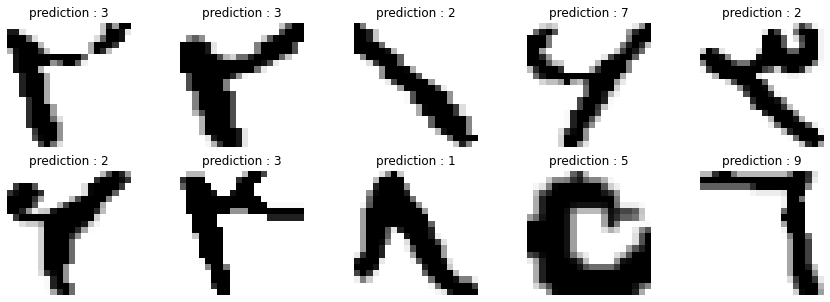

In [44]:
show_wrong_examples(GaussianNaiveBayes)

##### Bernoulli Model Wrong predictions:

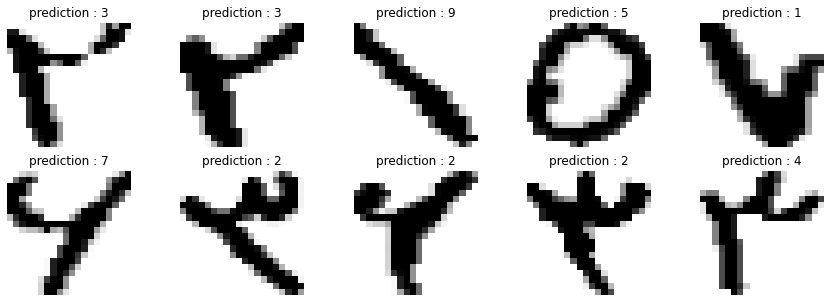

In [45]:
show_wrong_examples(BernoulliNaiveBayesModel)

### Sources

* [Laplace Smoothing](https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece)
* [Harmonic Mean](https://en.wikipedia.org/wiki/Harmonic_mean)
* [Multi-class Metrics](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1)